In [1]:
import sys
import os

# modify syspath directory to sys.path

package_path = os.path.abspath(os.path.join('..','core'))
if package_path not in sys.path:
    sys.path.append(package_path)

package_path = os.path.abspath(os.path.join('..','utils'))
if package_path not in sys.path:
    sys.path.append(package_path)

package_path = os.path.abspath(os.path.join('..'))
if package_path not in sys.path:
    sys.path.append(package_path)

import numpy as np
import qutip as qt
import math
import matplotlib.pyplot as plt

from IPython.display import HTML # both needed to disply gifs
from PIL import Image

# Import modules from the package
from core import create_hamiltonian as ch
from core import create_state as cs
from core import time_evo
from core.schmidt_solve import compute_schmidt_states_all_time
from core.eigen_ener_states import eigen_ener_states as eig
from utils.entropy import compute_VN, plot_VN, compute_VN_time
from utils import collapse_gif
from utils.collapse_gif import collapse_gif
from utils.display_gif import display_gif
from utils.distribution_gif import gif_distribution_eig_total
from utils.plot import plot_basic
from utils.plot import plot_with_binning
from utils.basic_functions import state_distribution_eig_tot
from utils.overlap import overlap
from utils.overlap import gif_schmidt_overlap
from utils.Interference import interference_plot

In [29]:
# Setting parameters for simulation TODO make a config file for this.

d1 = 10; d2 = 200; E_spacing = 4.0; E_int = 0.075; E_int2 = 0; E_env = 1; E_env2 = 0; w = [0,0,0,np.sqrt(0.3),0,0,0,np.sqrt(0.7),0,0]; envi=[0]; tmax = 10; ind_nb = 500; log = 0
env_sys=0
# Running the simulation and running the core functions
result, tlist, H_list, ket_list, info = time_evo(d1,d2,E_spacing, E_int, E_int2, E_env, E_env2,w,envi, tmax, ind_nb,log)
eigen = eig(H_list)
s_list = compute_schmidt_states_all_time(result, ind_nb)
ss_list = s_list[0]
se_list= s_list[1]
sv_list = s_list[2]
s_full_list=s_list[3]

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
from core.schmidt_solve import compute_schmidt_states_new
from core.schmidt_solve import compute_schmidt_full

def interference_plot(result,H_list,eigen,tlist,start_num=1000,end_num=1010):
    
    tlist=info[13]
    #set things up
    prob_list=[]
    prob_list2=[]
    prob_list3=[]
    eigenstates_total = eigen[1] 

    #get the schmidt values over time
    s_val_0=[]
    s_val_1=[]
    t_ind = range(len(tlist))
    for idx in t_ind:
        ss, se, sv = compute_schmidt_states_new(result, idx)
        s_val_0.append(sv[0])
        s_val_1.append(sv[1])


    # Create an array of integers between start_num and end_num
    arr = np.arange(start_num, end_num + 1)
    arr2 = np.arange(start_num, end_num)
    for i in arr:
        eig = eigenstates_total[i]
        prob=[]
        prob2=[]
        prob3=[]
        for idx in range(len(tlist)-1):
            prob.append(abs(np.vdot(compute_schmidt_full(result,idx+1,1), eig)) ** 2)
            prob2.append(abs(np.vdot(compute_schmidt_full(result,idx+1,2), eig)) ** 2)
            prob3.append(abs(np.vdot(result.states[idx].full(), eig)) ** 2)
            
        prob_list.append(prob)
        prob_list2.append(prob2)
        prob_list3.append(prob3)
        print(i)
    k=0
    b = 0
    for i in arr2:
        if prob_list[i-start_num+1][0]>b:
            b=prob_list[i-start_num+1][0]
            k=i-start_num+1
        #if prob_list3[i-start_num+1][2]>prob_list3[i-start_num][2]:
        #    k=i-start_num+1

    i = k
    j=start_num+k

    eig = eigenstates_total[j]
    interf=[]
    for idx in range(len(tlist)-1):
        interf.append(np.sqrt(s_val_0[idx]*s_val_1[idx])*(2*np.real(np.vdot(eig,compute_schmidt_full(result,idx+1,1)))*np.real(np.vdot(eig,compute_schmidt_full(result,idx+1,2)))+2*np.imag(np.vdot(eig,compute_schmidt_full(result,idx+1,1)))*np.imag(np.vdot(eig,compute_schmidt_full(result,idx+1,2)))))
        #interf.append(np.sqrt(s_val_0[idx]*s_val_1[idx])*(np.vdot(eig,compute_schmidt_full(result,idx+1,1))*(np.vdot(eig,compute_schmidt_full(result,idx+1,2)).conjugate()) + np.vdot(eig,compute_schmidt_full(result,idx+1,2))*(np.vdot(eig,compute_schmidt_full(result,idx+1,1)).conjugate())))

    weighted = np.multiply(prob_list[i], s_val_0[0:len(tlist)-1])+np.multiply(prob_list2[i], s_val_1[0:len(tlist)-1])
    weighted_plus_interf = weighted + interf
    plt.figure(figsize=(10, 6))
    plt.xscale('linear')
    plt.plot(tlist[0:len(tlist)-1], weighted)
    plt.plot(tlist[0:len(tlist)-1], weighted_plus_interf)
    plt.plot(tlist[0:len(tlist)-1], prob_list3[i])
    plt.plot(tlist[0:len(tlist)-1],np.multiply(prob_list[i], s_val_0[0:len(tlist)-1]))
    plt.plot(tlist[0:len(tlist)-1],np.multiply(prob_list2[i], s_val_1[0:len(tlist)-1]))
    plt.legend(['Weighted sum of schmidts without interference','Weighted sum of schmidts with interference','global state','s1','s2'])
    plt.title(f'Probability that various states be in energy eigenstates {j} over time')
    plt.xlabel('Time')
    plt.ylabel('Probability')
    plt.grid(True)
    plt.show()

def total_interference(result,eigen,info):
    eigenstates_total = eigen[1]
    EI=info[3]
    w=info[4]
    tlist=info[13]
    interference_list=[]

    for idx in range(len(tlist)-1):
        ss, se, sv = compute_schmidt_states_new(result, idx)
        s_val_0 = sv[0]
        s_val_1 = sv[1]

        state = result.states[idx+1].full()
        state1 = compute_schmidt_full(result,idx+1,1)
        state2 = compute_schmidt_full(result,idx+1,2)
        p=[abs(np.vdot(state, eigenstate)) ** 2 for eigenstate in eigenstates_total]
        p1=[abs(np.vdot(state1, eigenstate)) ** 2 for eigenstate in eigenstates_total]
        p2=[abs(np.vdot(state2, eigenstate)) ** 2 for eigenstate in eigenstates_total]
        interference = [abs(np.sqrt(s_val_0*s_val_1)*(2*np.real(np.vdot(eig,state1))*np.real(np.vdot(eig,state2))+2*np.imag(np.vdot(eig,state1))*np.imag(np.vdot(eig,state2)))) for eig in eigenstates_total]
        interference = np.sum(interference)
        interference_list.append(interference)  
    plt.plot(tlist[0:len(tlist)-1], interference_list)
    plt.title(f"Plot of the total absolute interference between Schmidts 1 and 2 over time for EI={EI}, w={w}")
    plt.xlabel("Time")
    plt.ylabel("Interference (sum of probability difference with the global state)")
    plt.show()
    
def all_interference(tlist,result,eigenstates_total,eigenenergies_total,EI,w):
    interference_list=[]
    for idx in range(len(tlist)-1):
        ss, se, sv = compute_schmidt_states_new(result, idx)
        s_val_0 = sv[0]
        s_val_1 = sv[1]

        state = result.states[idx+1].full()
        state1 = compute_schmidt_full(result,idx+1,1)
        state2 = compute_schmidt_full(result,idx+1,2)
        p=[abs(np.vdot(state, eigenstate)) ** 2 for eigenstate in eigenstates_total]
        p1=[abs(np.vdot(state1, eigenstate)) ** 2 for eigenstate in eigenstates_total]
        p2=[abs(np.vdot(state2, eigenstate)) ** 2 for eigenstate in eigenstates_total]
        interference = [abs(np.sqrt(s_val_0*s_val_1)*(2*np.real(np.vdot(eig,state1))*np.real(np.vdot(eig,state2))+2*np.imag(np.vdot(eig,state1))*np.imag(np.vdot(eig,state2)))) for eig in eigenstates_total]
        interference_list.append(interference)
    plt.plot(tlist[0:len(tlist)-1], interference_list)
    plt.title(f"Plot of the total absolute interference between Schmidts 1 and 2 over time for EI={EI}, w={w}")
    plt.xlabel("Time")
    plt.ylabel("Interference (sum of probability difference with the global state)")
    plt.show()


#What this graph tells me is that somehow the sum of the probabilities of the 2 worlds being in  
#an energy eigenstate is not conserved over time.

# I need to do a more through examination of this for more states
#I need to verify theoretically that this is what we expect.
#I need to make sure thjat the multiplication by schmidt weight mak es sense.



In [28]:
interference_plot(result,H_list,eigen,tlist)

IndexError: list index out of range

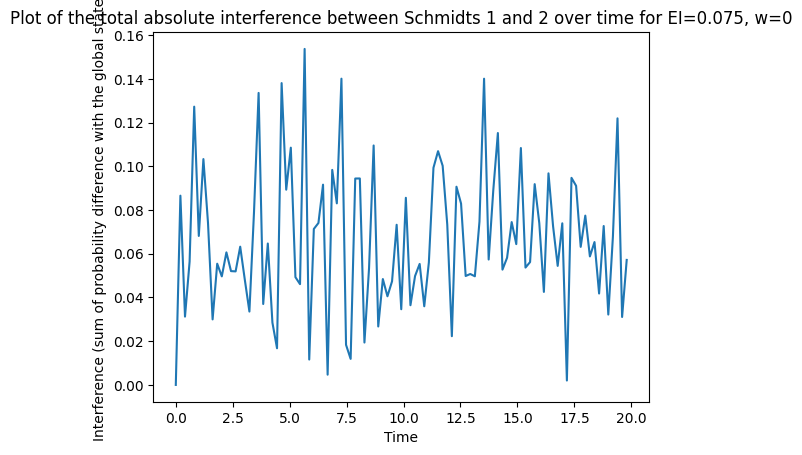

In [ ]:
total_interference(result,eigen,info)